# Reading in & visualizing GOES data from the Azure cloud
A guide to facilitate access data in the cloud, and to kickstart its analysis for educational and scientific purposes.

## Importing

In [2]:
import requests
import netCDF4
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
import cartopy.crs as ccrs
from cartopy import feature as cf
import xarray
from datetime import datetime
from azure.storage.blob import ContainerClient

import warnings
warnings.simplefilter('ignore')

## Defining
Run these cells until you reach the next section -- they're definitions to facilitate data access and visualization. 

In [25]:
def azure_plot(satellite, product):        
    # Load dataset
    resp = requests.get(f'https://goeseuwest.blob.core.windows.net/{satellite}/{fname}')
    nc = netCDF4.Dataset(fname, memory = resp.content)

    dataset = xarray.open_dataset(xarray.backends.NetCDF4DataStore(nc))
    dataset.load()

    # Fire Hot Spot! 
    if product[:-1] == "ABI-L2-FDC":
        dat = dataset.metpy.parse_cf('DQF')  

        # Identify variable
        plotting_var = dataset['DQF'].data 

        # Identify plotting coordinates
        x = dat.x
        y = dat.y
        geos = dat.metpy.cartopy_crs

        # Plotting
        fig = plt.figure(figsize=(12, 7), dpi=100)
        ax = plt.axes(projection=geos)
        cmap = plt.get_cmap('Set3', 6)
        plt.imshow(plotting_var, origin='upper', extent=(x.min(), x.max(), y.min(), y.max()), transform=geos,cmap=cmap)   

        label_list = ['Fire','No Fire','Opaque Cloud','Invalid Pixel','Invalid Pixel','Invalid Pixel']
        cbar = plt.colorbar(cmap = cmap)
        cbar.set_ticks([])
        for j, lab in enumerate(label_list):
            cbar.ax.text(1.5, (2 * j + 1) / (len(label_list)*2), lab, ha='left', va='baseline')   

        #units = dataset['Mask'].units
        #color_options = ['FFFF00','8BC34A','B3E5FC','2196F3', 'B2EBF2','C5CAE9']
        #plt.colorbar(cmap = "jet")
        title = "Fire Hot Spot"

    # Land Surface Temperature!
    elif product[:-1] == "ABI-L2-LST":
        dat = dataset.metpy.parse_cf('LST')

        # Identify variable and transform to Celsius
        plotting_var = dataset['LST'].data - 273.15

        # Identify plotting coordinates
        x = dat.x
        y = dat.y
        geos = dat.metpy.cartopy_crs

        # Plotting
        fig = plt.figure(figsize=(12, 7), dpi=100)
        ax = plt.axes(projection=geos)
        plt.imshow(plotting_var, origin='upper', extent=(x.min(), x.max(), y.min(), y.max()), transform=geos)   

        units = "Celsius"
        plt.colorbar(cmap = "jet", label = units)

        title = "Land Surface Temperature"

    # Lightning Detection!
    elif product == "GLM-L2-LCFA":
        dat = dataset.metpy.parse_cf('flash_energy')

        # Identify variable
        flash_energy = dataset['flash_energy'].data 

        # Identify plotting coordinates
        x_flash = dat.flash_lat
        y_flash = dat.flash_lon
        geos = dat.metpy.cartopy_crs  

        # Plotting
        fig = plt.figure(figsize=(12, 7), dpi=100)
        ax = plt.axes(projection=geos)
        lightning = plt.scatter(y_flash, x_flash,c = flash_energy, s = 5, label = "Flash Energy")

        units = dataset['flash_energy'].units 
        plt.colorbar(lightning, label = units)

        title = "Lightning Detection"

    # Rainfall Rate!
    elif product == "ABI-L2-RRQPEF":
        dat = dataset.metpy.parse_cf('RRQPE')

        # Identify variable
        plotting_var = dataset['RRQPE'].data 

        # Identify plotting coordinates
        x = dat.x
        y = dat.y
        geos = dat.metpy.cartopy_crs

        # Plotting
        fig = plt.figure(figsize=(12, 7), dpi=100)
        ax = plt.axes(projection=geos)
        plt.imshow(plotting_var, origin='upper',vmin=0, vmax=20, extent=(x.min(), x.max(), y.min(), y.max()), transform=geos)  

        units = dataset['RRQPE'].units
        plt.colorbar(cmap = "jet", label = units)

        title = "Rainfall Rate: \nQuantitative Precipitation \nEstimate"

    # Sea Surface Temperature!
    elif product == "ABI-L2-SSTF":
        dat = dataset.metpy.parse_cf('SST')

        # Only pixels with DQF = 0 should be used
        qc_dataset = dataset.where(dataset.DQF == 0, drop = False)    

        # Identify variable and transform to Celsius
        plotting_var = qc_dataset['SST'].data - 273.15

        # Identify plotting coordinates
        x = dat.x
        y = dat.y
        geos = dat.metpy.cartopy_crs

        # Plotting
        fig = plt.figure(figsize=(12, 7), dpi=100)
        ax = plt.axes(projection=geos)
        plt.imshow(plotting_var, origin='upper', extent=(x.min(), x.max(), y.min(), y.max()), transform=geos)   

        units = "Celsius"
        plt.colorbar(cmap = "jet", label = units)

        title = "Sea Surface (Skin) \nTemperature"

    # True color data!
    elif product[:-1] == "ABI-L2-MCMIP": 
        dat = dataset.metpy.parse_cf('CMI_C02')
        gamma = 2.2
        r = dataset['CMI_C02'].data; r = np.clip(r, 0, 1); r = np.power(r, 1/gamma)
        g = dataset['CMI_C03'].data; g = np.clip(g, 0, 1); g = np.power(g, 1/gamma)
        b = dataset['CMI_C01'].data; b = np.clip(b, 0, 1); b = np.power(b, 1/gamma)

        # Calculate the "True" Green
        g_true = 0.45 * r + 0.1 * g + 0.45 * b
        g_true = np.clip(g_true, 0, 1) 

        # Create a single RGB image for plotting
        plotting_var = np.dstack((r, g_true, b))

        # Identify plotting coordinates
        x = dat.x
        y = dat.y
        geos = dat.metpy.cartopy_crs

        # Plotting
        fig = plt.figure(figsize=(12, 7), dpi=100)
        ax = plt.axes(projection=geos)
        plt.imshow(plotting_var, origin='upper', extent=(x.min(), x.max(), y.min(), y.max()), transform=geos)  

        title = "True Color Data"

    nc.close()

    # For all plots
    ax.coastlines(resolution='50m', color='black', linewidth=0.25)
    ax.add_feature(ccrs.cartopy.feature.STATES, linewidth=0.25)

    scan_start = datetime.strptime(dataset.time_coverage_start, '%Y-%m-%dT%H:%M:%S.%fZ')

    plt.title(f"GOES-{satellite[-2:]} {title}", loc='left', fontweight='bold')
    plt.title('{}'.format(scan_start.strftime('%d %B %Y at %H:%M UTC')), loc='right')

    plt.show()
    plt.close(fig)
    plt.close("all")

In [43]:
def azure_animate(satellite, product):

    # Lightning Detection!
    if product == "GLM-L2-LCFA":
        
        # Reading in true color data
        fnames_truecolor = []
        data_files_truecolor = []
        
        for hour in range(int(shour), int(ehour)+1):
            name_string = (f"ABI-L2-MCMIPM/{year}/{doy}/{hour}/")

            for file in goes_container_client.walk_blobs(name_starts_with=name_string, delimiter='/'):
                data_files_truecolor.append(file.name)

        # Refine data files to chosen minute(s)
        for file in data_files_truecolor:
            file_start = file.split('_')[-3][8:12]
            file_end = file.split('_')[-2][8:12]
            if ((int(file_start[0:4]) >= int((str(shour) + str(smin)))) and (int(file_end[0:4]) <= int((str(ehour) + str(emin))))):
                fnames_truecolor.append(file)
                    
        fig, ax = plt.subplots()
        print(fnames_truecolor)
        def animate(i):    
            if len(fnames_truecolor) > 1:
                fname_truecolor = (fnames_truecolor[(round((len(fnames_truecolor)/len(fnames))*i))])[12:]    
            else:
                fname_truecolor = (fnames_truecolor[0])[12:]
            
            resp_truecolor = requests.get(f'https://goeseuwest.blob.core.windows.net/{satellite}/{fname_truecolor}')
            nc_truecolor = netCDF4.Dataset(fname_truecolor, memory = resp_truecolor.content)
            dataset_truecolor = xarray.open_dataset(xarray.backends.NetCDF4DataStore(nc_truecolor))
            dataset_truecolor.load()
            dat_truecolor = dataset_truecolor.metpy.parse_cf('CMI_C02')
            gamma = 2.2
            r = dataset_truecolor['CMI_C02'].data; r = np.clip(r, 0, 1); r = np.power(r, 1/gamma)
            g = dataset_truecolor['CMI_C03'].data; g = np.clip(g, 0, 1); g = np.power(g, 1/gamma)
            b = dataset_truecolor['CMI_C01'].data; b = np.clip(b, 0, 1); b = np.power(b, 1/gamma)

            # Calculate the "True" Green
            g_true = 0.45 * r + 0.1 * g + 0.45 * b
            g_true = np.clip(g_true, 0, 1) 
            plotting_var = np.dstack((r, g_true, b))

            # Identify plotting coordinates
            x_truecolor = dat_truecolor.x
            y_truecolor = dat_truecolor.y

            geos_truecolor = dat_truecolor.metpy.cartopy_crs

            fig.clear()
            ax = fig.add_subplot(projection=geos_truecolor)

            #lightning data 
            fname = (fnames[i])[12:]
            resp = requests.get(f'https://goeseuwest.blob.core.windows.net/{satellite}/{fnames[i]}')
            nc = netCDF4.Dataset(fnames[i], memory = resp.content)
            dataset = xarray.open_dataset(xarray.backends.NetCDF4DataStore(nc))
            dataset.load()
            dat = dataset.metpy.parse_cf('flash_energy')
            x = dat.flash_lat
            y = dat.flash_lon
            geos = dat.metpy.cartopy_crs 
            
            dataset.close()
            dataset_truecolor.close()

            plt.imshow(plotting_var, origin='upper', extent=(x_truecolor.min(), x_truecolor.max(), y_truecolor.min(), y_truecolor.max()), transform=geos_truecolor)
            ax.scatter(y, x, c = "blue", s=5, transform=geos)

            ax.coastlines(resolution='50m', color='black', linewidth=0.25)
            ax.add_feature(ccrs.cartopy.feature.STATES, linewidth=0.25)
            ax.set_extent([x_truecolor.min(), x_truecolor.max(), y_truecolor.min(), y_truecolor.max()], geos_truecolor)
            
            title = "Lightning Detection"
            scan_start = datetime.strptime(dataset.time_coverage_start, '%Y-%m-%dT%H:%M:%S.%fZ')
            plt.title(f"GOES-{satellite[-2:]} {title} \n{scan_start.strftime('%d %B %Y at %H:%M UTC')}", loc='left', fontweight='bold')

        ani = animation.FuncAnimation(fig, animate, repeat=True, frames=len(fnames)-1, interval=200)
        ani.save('GOES_animation.gif', writer='pillow')
        plt.close("all")
        
    # Land Surface Temperature!
    elif product[:-1] == "ABI-L2-LST":
        
        fig, ax = plt.subplots()
        
        def animate(i):    
            resp = requests.get(f'https://goeseuwest.blob.core.windows.net/{satellite}/{fnames[i]}')
            nc = netCDF4.Dataset(fnames[i], memory = resp.content)

            dataset = xarray.open_dataset(xarray.backends.NetCDF4DataStore(nc))
            dataset.load()
            dat = dataset.metpy.parse_cf('LST')
                
            # Identify variable and transform to Celsius
            plotting_var = dataset['LST'].data - 273.15
            # Identify plotting coordinates
            x = dat.x
            y = dat.y

            geos = dat.metpy.cartopy_crs
            
            dataset.close()

            fig.clear()
            ax = fig.add_subplot(projection=geos)
            plt.imshow(plotting_var, origin='upper', extent=(x.min(), x.max(), y.min(), y.max()), transform=geos, vmin=-40, vmax=40)

            ax.coastlines(resolution='50m', color='black', linewidth=0.25)
            ax.add_feature(ccrs.cartopy.feature.STATES, linewidth=0.25)
            ax.set_extent([x.min(), x.max(), y.min(), y.max()], geos)
            title = "Land Surface Temperature"
            scan_start = datetime.strptime(dataset.time_coverage_start, '%Y-%m-%dT%H:%M:%S.%fZ')
            plt.title(f"GOES-{satellite[-2:]} {title} \n{scan_start.strftime('%d %B %Y at %H:%M UTC')}", loc='left', fontweight='bold')
            plt.colorbar(label = "Celsius")
        ani = animation.FuncAnimation(fig, animate, repeat=True, frames=len(fnames)-1, interval=200)
        ani.save('GOES_LST_animation.gif', writer='pillow')
        plt.close("all")
        plt.close(fig)
            
    else:
        print("oops, i can't animate that yet")

## Begin editing your code here!
Select your desired satellite, products, date, and time. 

In [28]:
# Choose a satellite
satellite = "noaa-goes16" # options are 'noaa-goes16', 'noaa-goes17', or 'noaa-goes18'

# Choose a product
product = "GLM-L2-LCFA" # the last letter denotes scan type (Full Disk, CONUS/PACUS, or Meso)

# Choose a date
year = "2023" # must be 4 characters (i.e. "2022")
doy = "242" # must be 3 characters (i.e. "001")

# Choose a time
shour = "16" # must be 2 characters (i.e. "01")
smin = "00" # must be 2 characters (i.e. "01")

ehour = "16" # must be 2 characters (i.e. "01")
emin = "06" # must be 2 characters (i.e. "01")

# Search data files
fnames = []

for hour in range(int(shour), int(ehour)+1):
    storage_account_url = 'https://goeseuwest.blob.core.windows.net'
    goes_container_client = ContainerClient(account_url=storage_account_url, 
                                                         container_name=satellite,
                                                         credential=None)

    name_string = (f"{product}/{year}/{doy}/{hour}/")

    data_files = []
    for file in goes_container_client.walk_blobs(name_starts_with=name_string, delimiter='/'):
        data_files.append(file.name)

    # Refine data files to chosen minute(s)
    for file in data_files:
        file_start = file.split('_')[-3][8:12]
        file_end = file.split('_')[-2][8:12]
        if ((int(file_start[0:4]) >= int((str(shour) + str(smin)))) and (int(file_end[0:4]) <= int((str(ehour) + str(emin))))):
            fnames.append(file)
            
print(f"This search resulted in {len(fnames)} data files.")        

This search resulted in 20 data files.


## Visualize your data

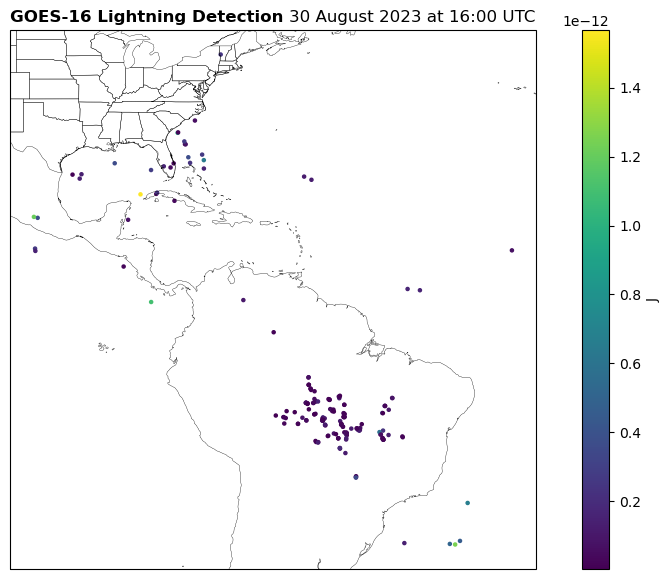

In [29]:
for f in range(0, 1):  # just plotting the first image of your search
# for f in range(0, len(fnames)): # plotting all searched images
    fname = fnames[f] 
    
    azure_plot(satellite, product)

['ABI-L2-MCMIPM/2023/242/16/OR_ABI-L2-MCMIPM1-M6_G16_s20232421600279_e20232421600343_c20232421600426.nc', 'ABI-L2-MCMIPM/2023/242/16/OR_ABI-L2-MCMIPM1-M6_G16_s20232421600551_e20232421601008_c20232421601084.nc', 'ABI-L2-MCMIPM/2023/242/16/OR_ABI-L2-MCMIPM1-M6_G16_s20232421601251_e20232421601308_c20232421601384.nc', 'ABI-L2-MCMIPM/2023/242/16/OR_ABI-L2-MCMIPM1-M6_G16_s20232421601551_e20232421602008_c20232421602086.nc', 'ABI-L2-MCMIPM/2023/242/16/OR_ABI-L2-MCMIPM1-M6_G16_s20232421602251_e20232421602308_c20232421602383.nc', 'ABI-L2-MCMIPM/2023/242/16/OR_ABI-L2-MCMIPM1-M6_G16_s20232421602551_e20232421603008_c20232421603079.nc', 'ABI-L2-MCMIPM/2023/242/16/OR_ABI-L2-MCMIPM1-M6_G16_s20232421603251_e20232421603308_c20232421603384.nc', 'ABI-L2-MCMIPM/2023/242/16/OR_ABI-L2-MCMIPM1-M6_G16_s20232421603551_e20232421604008_c20232421604088.nc', 'ABI-L2-MCMIPM/2023/242/16/OR_ABI-L2-MCMIPM1-M6_G16_s20232421604251_e20232421604308_c20232421604382.nc', 'ABI-L2-MCMIPM/2023/242/16/OR_ABI-L2-MCMIPM1-M6_G16_s2

IndexError: list index out of range

Error in callback <function _draw_all_if_interactive at 0x7f3734e3ad40> (for post_execute):


OSError: [Errno -51] NetCDF: Unknown file format: 'M/2023/242/16/OR_ABI-L2-MCMIPM1-M6_G16_s20232421600279_e20232421600343_c20232421600426.nc'

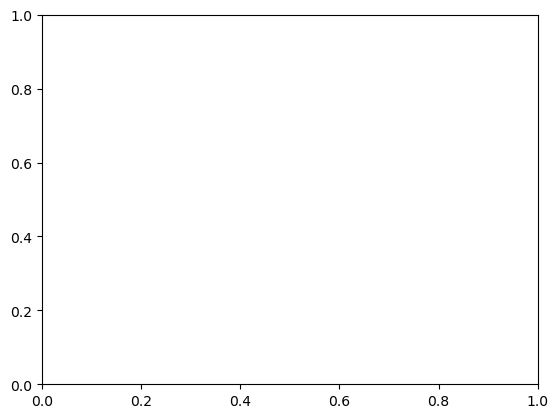

In [44]:
# Plot an animation of all searched frames

azure_animate(satellite, product)

In [ ]:
# Your analysis here!

**GOES Product Documentation:**
- https://www.goes-r.gov/products/ (Broad explanation of all products)
- https://www.star.nesdis.noaa.gov/goesr/ (Algorithm & product description)
- http://cimss.ssec.wisc.edu/goes/OCLOFactSheetPDFs/ (Quick guides)
- https://github.com/awslabs/open-data-docs/blob/main/docs/noaa/noaa-goes16/README.md (Variables & product names)

**Coding Sources:**
- https://unidata.github.io/python-gallery/examples/mapping_GOES16_TrueColor.html#sphx-glr-download-examples-mapping-goes16truecolor-py
- https://unidata.github.io/python-training/gallery/mapping_goes16_truecolor/
- https://fire.trainhub.eumetsat.int/docs/figure3_GOES17_L1B_and_L2.html
- https://unidata.github.io/python-training/gallery/mapping_goes16_truecolor/

**CSP Access:**     
AWS: https://registry.opendata.aws/noaa-goes/   
Google: https://console.cloud.google.com/marketplace/product/noaa-public/goes   
Azure: https://microsoft.github.io/AIforEarthDataSets/data/goes-r.html   